#Project Milestone - Feature Learning for Video Feedback
##Victor Shepardson, Dartmouth College Digital Musics

The goal of this project is to discover aesthetically interesting digital video feedback processes by incorporating learned features into a hand constructed feedback process.

Consider a video feedback process defined by the mapping from images to images $x_t = \Delta_\phi(x_{t-1})$, where $\Delta$ is a transition function, $\phi$ is a parameterization which may be spatially varying or interactively controlled, and $x_t$ is the image at time step $t$.

Additionally suppose we have a deep autoencoder $\gamma$ for images: $$h^{\ell+1} = \gamma_\ell(h^\ell)$$ $$h^{\ell} \approx \gamma_\ell^{-1}(h^{\ell+1})$$ $$h^0 = x$$

Combining these two concepts, we can define a new feedback process where position in the feature hierarchy acts like another spatial dimension:
$$h_t^\ell = \Delta_\phi( h_{t-1}^\ell, \gamma_{\ell-1}(h_{t-1}^{l-1}), \gamma_\ell^{-1}(h_{t-1}^{\ell+1}) )$$

The goal then is to learn a deep autoencoder which represents abstract image features and admits layer-wise encoding and decoding as above. I propose a convolutional pooling autoencoder based on the convolutional autoencoders of [Masci et al.][1] and the upsampling layers of [Long et al.][2].

Below I have trained a single layer pooled convolutional autoencoder on the CIFAR-10 dataset using [caffe][3]. The code is available at my [GitHub](https://github.com/victor-shepardson/feature-feedback). I use a filter size of 3x3x3 and 2x2 max pooling. For this experiment, the data dimensionality is preserved in the intermediate representation by using 12 filters (3 input colors x factor of 4 lost to pooling). I trained on the L2 reconstruction error with momentum but no other regularization. Test error was found to decrease consistently from about 100 at random initialization to about 1.3.

[1]: http://people.idsia.ch/~masci/papers/2011_icann.pdf "Masci, J., Meier, U., Cireşan, D., & Schmidhuber, J. (2011). Stacked convolutional auto-encoders for hierarchical feature extraction. In Artificial Neural Networks and Machine Learning–ICANN 2011 (pp. 52-59). Springer Berlin Heidelberg."

[2]: http://arxiv.org/pdf/1411.4038v1.pdf "Long, J., Shelhamer, E., & Darrell, T. (2014). Fully convolutional networks for semantic segmentation. arXiv preprint arXiv:1411.4038."

[3]: http://caffe.berkeleyvision.org/ "Caffe Deep learning framework by the BVLC"


In [2]:
#get caffe and pycaffe set up

import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
%matplotlib inline

#assuming feature-feedback repo and caffe root are in the same directory
caffe_root = '../../caffe/'
import sys
sys.path.insert(0, caffe_root+'python')

import caffe
from caffe.proto import caffe_pb2
#I have compiled caffe for CPU only (nvidia GPUs only)
caffe.set_mode_cpu()

In [ ]:
#run this cell to solve the model defined in the solver_file
solver_file = 'autoencoder-0-solver.prototxt'
solver = caffe.get_solver(solver_file);
solver.solve();

In [24]:
#load the model trained by the previous cell
#(and saved elsewhere in the repo) and set it up on test data
model_def_file = 'autoencoder-0.prototxt'
model_file = '../bin/cifar-tanh-20epoch-unregularized.caffemodel'
net = caffe.Net(model_def_file, model_file, caffe.TEST)
#run a batch
net.forward()

{'l2_error': array(1.4730193614959717, dtype=float32)}

# Visualize Reconstruction
We can pull inputs and reconstructions straight out of the caffe Net and manually undo the mean subtraction:

In [3]:
#load the cifar mean into numpy array
blob = caffe_pb2.BlobProto()
data = open('../../caffe/examples/cifar10/mean.binaryproto').read()
blob.ParseFromString(data)
mean = caffe.io.blobproto_to_array(blob)[0].transpose([1,2,0])/256

In [4]:
def get_reconstructions(net, mean, n, compare=0):
    inputs = np.hstack([ np.copy(net.blobs['data'].data[i]).transpose([1,2,0])+mean for i in range(n)])
    outputs = np.hstack([ np.copy(net.blobs['decode1neuron'].data[i]).transpose([1,2,0])+mean for i in range(n)])
    #clamp the reconstruction to [0,1]
    #even with tanh activation outputs can be out of bounds once mean is added back
    np.clip(outputs, 0, 1, outputs)
    #compare to cubic resampling through the intermediate spatial resolution
    if compare>0:
        comparisons = np.dsplit(np.copy(inputs), inputs.shape[2])
        comparisons = [scipy.ndimage.zoom(np.squeeze(c), 1./compare, order=3) for c in comparisons]
        comparisons = [scipy.ndimage.zoom(c, compare, order=3) for c in comparisons]
        comparisons = np.dstack(comparisons)
        np.clip(comparisons, 0, 1, comparisons)
        return (inputs, outputs, comparisons)
    return (inputs, outputs)
def vis_reconstructions(rec):
    disp = np.vstack(rec)
    plt.imshow(disp, interpolation='None')

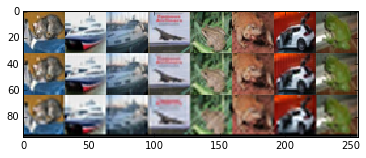

In [60]:
rec = get_reconstructions(net, mean, 8, compare=2)
vis_reconstructions(rec)

 CIFAR-10 test inputs on top, reconstructions in the middle, cubic interpolation comparison on the bottom. Looks good!

#Visualize Filters

Now let's pull our 12 3x3x3 filters out of the model

In [5]:
def get_filters(net):
    filters = np.copy(net.params['encode1'][0].data).transpose([0,2,3,1])
    biases = np.copy(net.params['encode1'][1].data)
    print biases
    return filters
def vis_filters(filters, rows):
    #normalize preserving 0 = 50% gray
    filters/=2*abs(filters).max()
    filters+=.5
    disp = np.hstack([np.pad(f,[(1,1),(1,1),(0,0)],'constant', constant_values=[.5]) for f in filters])
    disp = np.vstack(np.hsplit(disp,rows))
    return disp
    

[-0.36862749 -0.1923824  -0.22088723 -0.12164118 -0.10508166 -0.49331141
 -0.53125817 -0.48567948 -0.44001433 -0.39040077 -0.32423615 -0.1737113 ]


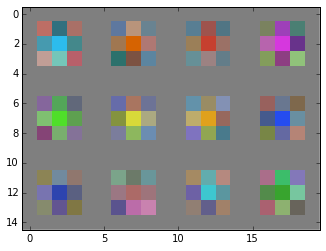

In [154]:
filters = get_filters(net)
disp = vis_filters(filters, 3)
plt.imshow(disp, interpolation='none')

Looks like the network mostly learned localized primary and secondary color detectors. Weird! These aren't the usual edge filters, but they seem to at least have some plausible structure.

#Visualize filter responses

Now let's see the (max pooled) reponses of all 12 filters to a few inputs: 

In [6]:
def get_responses(net, layer, filts, n):
    reps = np.hstack([ net.blobs[layer].data[i].transpose([1,2,0]) for i in range(n)])
    # normalize preserving 0 = 50% gray
    reps/=2*abs(reps).max()
    reps+=.5
    reps = np.vstack(np.dsplit(reps, filts))
    return reps.squeeze()    
def vis_responses(reps):
    plt.figure(figsize=(10,10))
    plt.imshow(reps, interpolation='none', cmap='coolwarm')

(192, 128, 1)


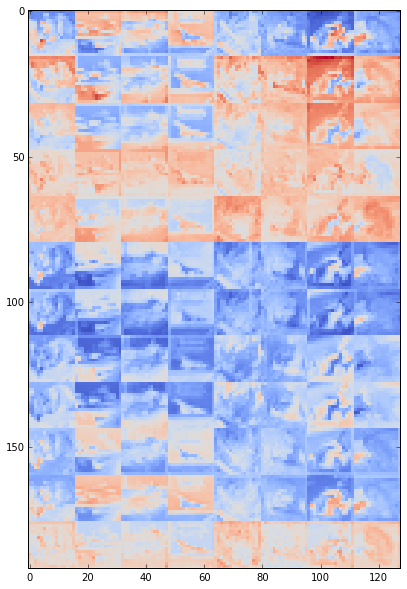

In [156]:
reps = get_responses(net, 'pool1', 12, 8)
vis_responses(reps)

Pooled activations for each of 12 filters. Red is positive response, blue negative.

#Dimensionality Reduction

Let's try fewer filters, reducing dimensionality in the intermediate representation

In [3]:
solver_file = 'autoencoder-1-solver.prototxt'
solver = caffe.get_solver(solver_file)
solver.solve()

In [66]:
model_def_file = 'autoencoder-1.prototxt'
model_file = '../bin/cifar-tanh-20epoch-squeezing.caffemodel'
net = caffe.Net(model_def_file, model_file, caffe.TEST)
#run a batch
net.forward()

{'l2_error': array(2.5404462814331055, dtype=float32)}

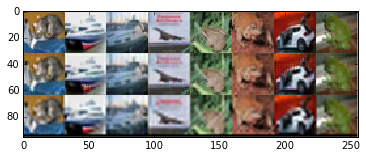

In [67]:
rec = get_reconstructions(net, mean, 8, compare=2)
vis_reconstructions(rec)

This time there's some clear loss of detail. The filters are doing something, though; looks better than cubic interpolation

[-0.09201549 -0.12697266 -0.11692226 -0.10681173 -0.09015708 -0.11839788]


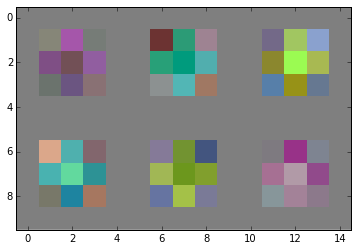

In [24]:
filters = get_filters(net)
disp = vis_filters(filters, 2)
plt.imshow(disp, interpolation='none')

These filters appear to be learning color gradients

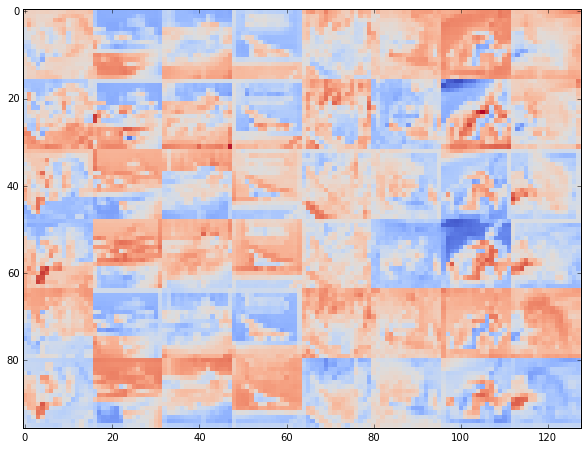

In [31]:
reps = get_responses(net, 'pool1', 6, 8)
vis_responses(reps)

# Another Architecture

What changes with 3x3 pooling and 18 filters?

In [3]:
solver_file = 'autoencoder-2-solver.prototxt'
solver = caffe.get_solver(solver_file)
solver.solve()

In [64]:
model_def_file = 'autoencoder-2.prototxt'
model_file = '../bin/cifar-tanh-20epoch-squeezing-pool3.caffemodel'
net = caffe.Net(model_def_file, model_file, caffe.TEST)
#run a batch
net.forward()

{'l2_error': array(5.593883514404297, dtype=float32)}

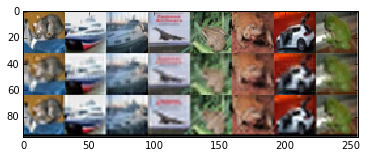

In [65]:
rec = get_reconstructions(net, mean, 8, compare=2)
vis_reconstructions(rec)

This looks worse than cubic interpolation despite the larger intermediate representation (2/3 of original size vs 1/4). Might have needed more training time.

[-0.50788909 -0.43275061 -1.14355206  0.10364168 -1.34963369 -0.09600195
 -0.22224261  0.43634155  0.22673954 -0.07008067 -0.12105633 -0.42311984
 -0.03443978 -1.11161244 -0.13477272 -1.06063521 -0.22926652 -0.48990318]


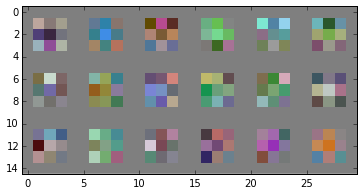

In [12]:
filters = get_filters(net)
disp = vis_filters(filters, 3)
plt.imshow(disp, interpolation='none')

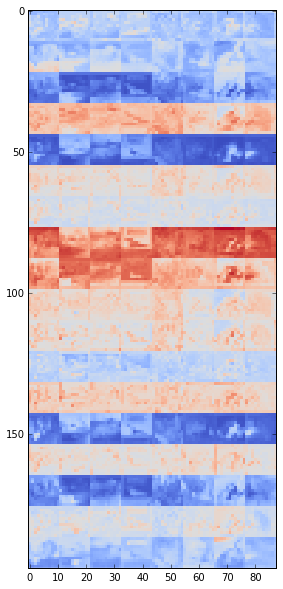

In [14]:
reps = get_responses(net, 'pool1', 18, 8)
vis_responses(reps)

#Deeper Network

Let's try training two layers of the first architecture above:

In [2]:
solver_file = 'autoencoder-3-solver.prototxt'
solver = caffe.get_solver(solver_file)
solver.solve()

In [77]:
model_def_file = 'autoencoder-3.prototxt'
model_file = '../bin/cifar-tanh-20epoch-2layer.caffemodel'
net = caffe.Net(model_def_file, model_file, caffe.TEST)
#run a batch
net.forward()

{'l2_error': array(3.1616454124450684, dtype=float32)}

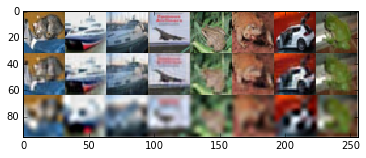

In [78]:
rec = get_reconstructions(net, mean, 8, compare=4)
vis_reconstructions(rec)

Worse than 1 layer, but probably could have benefited from more training. No contest with cubic interpolation.

[ 0.13225429 -0.10828878 -0.02391739  0.04887676 -0.10171439 -0.05522881
  0.01416261  0.00705651 -0.05120158 -0.03273212  0.01444453 -0.03893932]


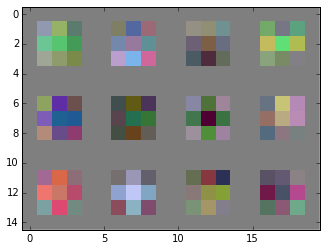

In [79]:
filters = get_filters(net)
disp = vis_filters(filters, 3)
plt.imshow(disp, interpolation='none')

I would hang these filters on my wall

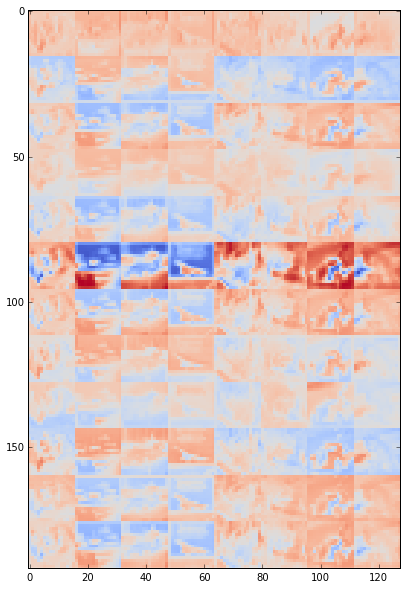

In [81]:
#map triples of filters to colors
reps = get_responses(net, 'pool1', 12, 8)
vis_responses(reps)

#Going Deeper

Can we train 3 layers from scratch?

In [17]:
solver_file = 'autoencoder-4-solver.prototxt'
solver = caffe.get_solver(solver_file)
solver.solve()

In [74]:
model_def_file = 'autoencoder-4.prototxt'
model_file = '../bin/cifar-tanh-40epoch-3layer.caffemodel'
net = caffe.Net(model_def_file, model_file, caffe.TEST)
#run a batch
net.forward()

{'l2_error': array(7.721501350402832, dtype=float32)}

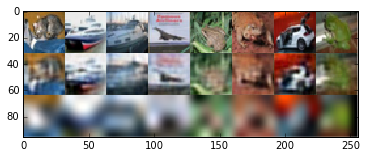

In [76]:
rec = get_reconstructions(net, mean, 8, compare=8)
vis_reconstructions(rec)

Again, we are recovering a lot of spatial detail. Deeper is still worse, will be interesting to see how heavier training improves the situation

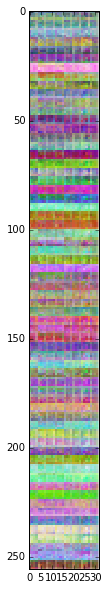

In [22]:
#map triples of filters to colors
reps = get_responses(net, 'pool3', 64, 8)
vis_responses(reps)

[-0.07059465 -0.10024329  0.10659036  0.10958434  0.01271083 -0.01800147
 -0.07352163 -0.05648752  0.22933678  0.09903485  0.1505022  -0.08800486]


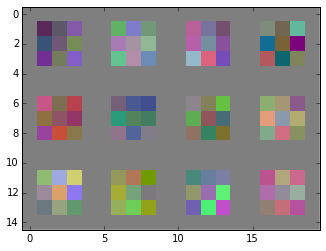

In [23]:
filters = get_filters(net)
disp = vis_filters(filters, 3)
plt.imshow(disp, interpolation='none')

These first-layer filters are hard to interpret, but do seem to have some internal color coordination and symmetry. Most deep convolutional architectures start with a large number of filters; maybe having just 4x the number of colors is asking each filter to do too many things. Then again, maybe that isn't a problem for anything besides filter visualization.

#Rectifiers

ReLUs have helped to train very deep networks. For a classifier, it's not a problem to have zero mean inputs but nonnegative hidden+output layers. For this application, we rely on hidden layers having the same image properties as the input. Can we get rid of the mean subtraction and use a non negative image representation with ReLU instead of tanh units? Let's start back at the 1-layer, dimensionality preserving autoencoder:

In [ ]:
solver_file = 'autoencoder-5-solver.prototxt'
solver = caffe.get_solver(solver_file)
solver.solve()

In [ ]:
model_def_file = 'autoencoder-5.prototxt'
model_file = '../bin/cifar-relu-20epoch.caffemodel'
net = caffe.Net(model_def_file, model_file, caffe.TEST)
#run a batch
net.forward()